# 1. 라이브러리 & 설정

* **[런타임] ▶ [런타임 유형 변경] ▶ [하드웨어 가속기]: GPU 설정**

## 1.1. 라이브러리 업그레이드, 한글 글꼴 설치

In [ ]:
# Step 1. Matplotlib 업그레이드
!pip install matplotlib -U 
!pip install seaborn -U
!pip install pandas -U

# Step 2. 한글 설치 및 사용 설정
!apt-get -qq install -y fonts-nanum
!fc-cache -fv  
!rm ~/.cache/matplotlib -rf

# Step 3. 셀 실행 후 런타임 재시작

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existe

In [ ]:
# Step 4. seaborn 환경 설정
import seaborn as sns

sns.set_style("ticks")
sns.set_palette("colorblind")
sns.set_context("talk")

# Step 5. 한글 글꼴 설정
import matplotlib.pyplot as plt

plt.rcParams['font.family']=['NanumGothic', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

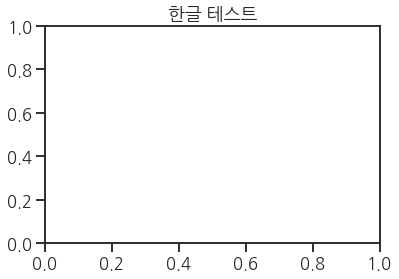

In [ ]:
# 한글 설정 확인
%matplotlib inline

plt.title("한글 테스트")
plt.show()

## 1.2. 필수 라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd
from copy import deepcopy
import pickle
from tqdm.auto import tqdm

## 1.3. 시각화 기본 설정

In [ ]:
# font properties
plt.rcParams["mathtext.fontset"] = "cm"
font_label = {"color":"gray"}
font_title = {"color":"k"}
font_metrics = {'color':'k', 'fontsize':"medium"}

# colors
c_train = "green"
c_val = "orange"
c_test = "magenta"

## 1.4. PyTorch 불러오기

In [ ]:
import torch
from torch import nn
from torch import optim

## 1.5. GPU 사용 설정

In [ ]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"# DEVICE {i}: {torch.cuda.get_device_name(i)}")
        print("- Memory Usage:")
        print(f"  Allocated: {round(torch.cuda.memory_allocated(i)/1024**3,1)} GB")
        print(f"  Cached:    {round(torch.cuda.memory_reserved(i)/1024**3,1)} GB\n")
        
else:
    print("# GPU is not available")
    
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# GPU is not available


## 1.6. Random seed 설정

In [ ]:
rng = np.random.RandomState(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# 2. Data

## 2.1. Dataset 불러오기

In [ ]:
df_peng = sns.load_dataset("penguins")  # 펭귄 데이터셋
df_peng = df_peng.dropna()              # 결측치 제거

## 2.2. X, y 분할 : 펭귄 체중 구하기 (Regression)

In [ ]:
y = df_peng["body_mass_g"]
X = df_peng.drop("body_mass_g", axis=1)

## 2.3. training , validation, testing 분할

### 2.3.1. (3:1:1) stratified sampling

In [ ]:
from sklearn.model_selection import train_test_split

X_Train, X_test, y_Train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng, 
                                                    stratify=X[["species", "island", "sex"]])
X_train, X_val, y_train, y_val = train_test_split(X_Train, y_Train, test_size=0.25, random_state=rng, 
                                                    stratify=X_Train[["species", "island", "sex"]])

### 2.3.2. 시각화: 데이터 분할

* categorical features

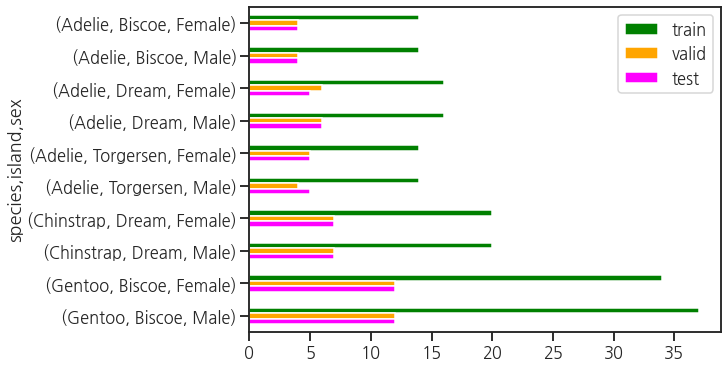

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

cols_cat = ["species", "island", "sex"]
df_tmp = 0
for i, (X, col) in enumerate(zip([X_train, X_val, X_test], ["train", "valid", "test"])):
    if isinstance(df_tmp, int):
        df_tmp = pd.DataFrame(X[cols_cat].value_counts(), columns=[col]).sort_index()
    else:
        df_tmp = pd.concat([df_tmp, pd.DataFrame(X[cols_cat].value_counts(), columns=[col]).sort_index()], axis=1)

df_tmp.plot.barh(ax=ax, color={"train":c_train, "valid":c_val, "test":c_test}).invert_yaxis()

* numerical features

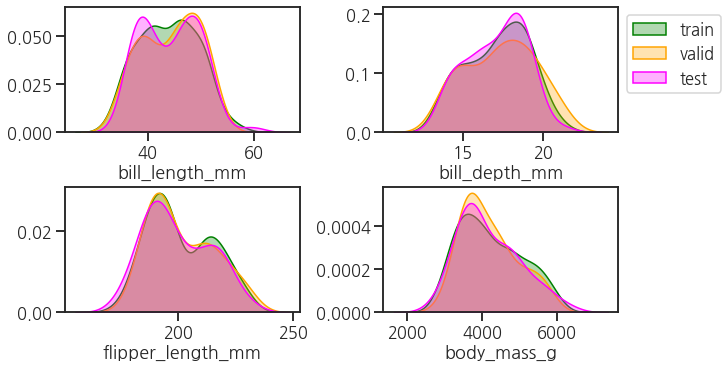

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 5), constrained_layout=True)

cols_num = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]
axs = axes.ravel()

# numerical X features
for ax, col in zip(axes.ravel(), cols_num):
    for X, c in zip([X_train, X_val, X_test], [c_train, c_val, c_test]):
        sns.kdeplot(x=col, data=X, ax=ax, fill=True, alpha=0.3, color=c)
        ax.set_ylabel("")

# y feature
for y, c in zip([y_train, y_val, y_test], [c_train, c_val, c_test]):
    sns.kdeplot(y, ax=axes[1, 1], fill=True, alpha=0.3, color=c)
    axes[1, 1].set_ylabel("")

axes[0, 1].legend(handles=axes[1, 1].collections, labels=["train", "valid", "test"],
                  loc="upper left", bbox_to_anchor=(1, 1))

# 3. Neural Network

## 3.1. PyTorch

### 3.1.1. network and loss

In [ ]:
# neural network: ninput(12)-16-16-12-8-1
class Net(nn.Module):
    def __init__(self, ninput=12):
        super().__init__()
        self.layer0 = nn.Linear(ninput, 16)
        self.layer1 = nn.Linear(16, 16)
        self.layer2 = nn.Linear(16, 12)
        self.layer3 = nn.Linear(12, 8)
        self.layer4 = nn.Linear(8, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer0(x))
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x)
        return x

# loss: RMSE
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
    def forward(self, true, pred):
        loss = torch.sqrt(self.mse(true, pred) + self.eps)
        return loss

### 3.1.2. preprocessor using Pipeline

In [ ]:
# preprocessors
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessings for Categorical and Numerical features
def get_concat(cols_cat=cols_cat, cols_num=cols_num, degree=1):
    # categorical features: one-hot encoding
    cat_features = cols_cat
    cat_transformer = OneHotEncoder(sparse=False, handle_unknown="ignore")

    # numerical features: standard scaling & polynomial features
    num_features = cols_num
    num_transformer = Pipeline(steps=[("polynomial", PolynomialFeatures(degree=degree)),
                                      ("scaler", StandardScaler())])
    
    numcat = ColumnTransformer(transformers=[("categorical", cat_transformer, cat_features),
                                          ("numerical", num_transformer, num_features)])
    return numcat

# Float64 to Float32 for PyTorch
class FloatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.array(X, dtype=np.float32)


# preprocessing Pipeline
def get_preprocessor(cols_cat=cols_cat, cols_num=cols_num, degree=1):
    concat = get_concat(cols_cat=cols_cat, cols_num=cols_num, degree=degree)
    ft = FloatTransformer()

    pipeline= Pipeline(steps=[("concat", concat), 
                              ("float64to32", ft)])
    return pipeline

In [ ]:
from sklearn import set_config
set_config(display='diagram')

preprocessor = get_preprocessor()
preprocessor

Pipeline(steps=[('concat',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['species', 'island', 'sex']),
                                                 ('numerical',
                                                  Pipeline(steps=[('polynomial',
                                                                   PolynomialFeatures(degree=1)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm'])])),
                ('float64to32', FloatTransformer())])

In [ ]:
# Xs
X_train_np = preprocessor.fit_transform(X_train)
X_val_np = preprocessor.transform(X_val)
X_test_np = preprocessor.transform(X_test)

X_train_tensor = torch.Tensor(X_train_np).to(device)
X_val_tensor = torch.Tensor(X_val_np).to(device)
X_test_tensor = torch.Tensor(X_test_np).to(device)

# ys
y_train_tensor = torch.Tensor(y_train.values).to(device)
y_val_tensor = torch.Tensor(y_val.values).to(device)
y_test_tensor = torch.Tensor(y_test.values).to(device)

In [ ]:
# Xs
print(f"# dtype of X_train:\t\t{X_train.dtypes.values}")
print(f"# dtype of X_train_np:\t\t{X_train_np.dtype}")
print(f"# dtype of X_train_tensor:\t{X_train_tensor.dtype}\n")

# ys
print(f"# dtype of y_train:\t\t{y_train.dtype}")
print(f"# dtype of y_train_tensor:\t{y_train_tensor.dtype}")

# dtype of X_train:		[dtype('O') dtype('O') dtype('float64') dtype('float64') dtype('float64')
 dtype('O')]
# dtype of X_train_np:		float32
# dtype of X_train_tensor:	torch.float32

# dtype of y_train:		float64
# dtype of y_train_tensor:	torch.float32


### 3.1.3. training & validation

  0%|          | 0/1000 [00:00<?, ?it/s]

[0/1000] train_loss: 4303.2822265625,  valid_loss: 4250.70068359375
[100/1000] train_loss: 3756.332763671875,  valid_loss: 3660.7578125
[200/1000] train_loss: 361.5039367675781,  valid_loss: 295.07098388671875
[300/1000] train_loss: 289.6954650878906,  valid_loss: 275.11474609375
[400/1000] train_loss: 282.8603210449219,  valid_loss: 271.21929931640625
[500/1000] train_loss: 280.0774230957031,  valid_loss: 271.82470703125
[600/1000] train_loss: 278.8686828613281,  valid_loss: 272.6382141113281
[700/1000] train_loss: 278.05108642578125,  valid_loss: 273.4883728027344
[800/1000] train_loss: 276.9803466796875,  valid_loss: 275.0303039550781
[900/1000] train_loss: 276.1494140625,  valid_loss: 275.9771728515625


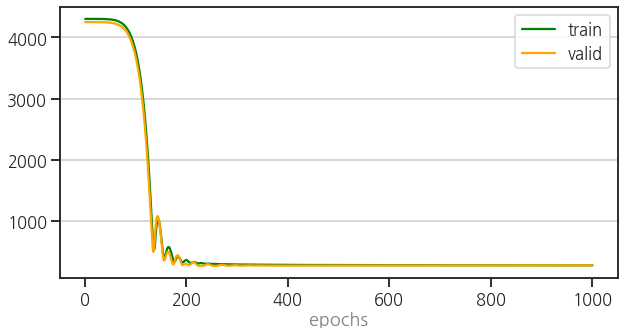

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

net = Net().to(device)                      # Neural Network 생성
loss_fn = RMSELoss()                        # loss function 지정
optimizer = optim.Adam(net.parameters(), 
                       lr=1e-3)             # learning rate = 0.001
epochs = 1000                               # number of max. epochs
onecycle = OneCycleLR(optimizer,            # learning rate scheduler
                     max_lr=0.1, total_steps=epochs)

def train(device, model, epochs, loss_fn, optimizer, X_train, y_train, X_val=None, y_val=None, 
          lr_scheduler=None, early_stopping=1, patience=3, plot=True):
    loss_trains = []                            # train loss 
    loss_vals = []                              # validation loss
    loss_last = np.inf
    patience_ = 0

    val = False
    if X_val != None and y_val != None:
        val = True

    for epoch in tqdm(range(epochs)):
        model.train()                           # sets the model in training mode

        optimizer.zero_grad()                   # gradient reset
        y_pred = model.forward(X_train_tensor)  # forward propagation
        loss_ = loss_fn(y_pred, y_train_tensor.view(-1, 1)) # loss 계산
        loss_.backward()                        # back propagation
        optimizer.step()                        # weight update
        
        if lr_scheduler:
            lr_scheduler.step()                 # learning rate scheduler


        loss = loss_.item()
        loss_trains.append(loss)                # collect train loss

        # progress message
        prog_msg = f"[{epoch}/{epochs}] train_loss: {loss}"

        # validation
        if val == True:
            loss = validate(device, model, loss_fn, X_val, y_val)
            loss_vals.append(loss)          # collect validation loss
            prog_msg += f",  valid_loss: {loss}"
        
        if epoch % 100 == 0:
            print(prog_msg)

        # early stopping : patience회 이상 loss_val이 감소하지 않을 때
        if early_stopping > 0 and (loss > loss_last):
            patience_ += 1
            
            if patience_ >= patience:
                print(f"early stopping: {loss_last}")
                break
        
        loss_last = loss

    if plot:
        if val:
            plot_epoch(loss_trains, loss_vals)
        else:
            plot_epoch(loss_trains)

    return model


def validate(device, model, loss_fn, X_val, y_val):
    model.eval()                            # sets the model in evaluating mode

    with torch.no_grad():                   # gradient 계산 없이 진행
        y_pred = net.forward(X_val)         # forward propagation
        loss = loss_fn(y_pred, y_val.view(-1, 1))       # loss 계산
    
    return loss.item()


def plot_epoch(loss_trains, loss_vals=None, ax=None):
    if ax == None:
        fig, ax = plt.subplots(figsize=(10, 5))
        
    ax.plot(list(range(1, len(loss_trains)+1)), loss_trains, c=c_train, label="train")
    if loss_vals != None:
        ax.plot(list(range(1, len(loss_vals)+1)), loss_vals, c=c_val, label="valid")
    ax.grid(axis="y")
    ax.set_xlabel("epochs", fontdict=font_label)
    ax.legend()

    return ax

net = train(device, net, epochs, loss_fn, optimizer, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
            lr_scheduler=None, early_stopping=0)

### 3.1.4. parity plot

In [ ]:
import matplotlib.colors as colors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def get_metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = mean_squared_error(true, pred, squared=False)
    r2 = r2_score(true, pred)
    return mae, rmse, r2

def plot_parity(true, pred, kind="scatter", 
                xlabel="true", ylabel="predict", title="", 
                hist2d_kws=None, scatter_kws=None, kde_kws=None,
                equal=True, metrics=True, metrics_position="lower right",
                figsize=(5, 5), ax=None, filename=None):
    
    fig = None
    if not ax:
        fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)

    # data range
    val_min = min(true.min(), pred.min())
    val_max = max(true.max(), pred.max())
    data_range = val_max - val_min

    # data plot
    if "scatter" in kind:
        if not scatter_kws:
            scatter_kws={'color':'green', 'alpha':0.5}
        ax.scatter(true, pred, **scatter_kws)
    elif "hist2d" in kind:
        if not hist2d_kws:
            hist2d_kws={'cmap':'Greens', 'vmin':1, 'bins':30}
        ax.hist2d(true, pred, **hist2d_kws)
    elif "kde" in kind:
        if not kde_kws:
            kde_kws={'cmap':'viridis', 'levels':5}
        sns.kdeplot(x=true, y=pred, **kde_kws, ax=ax)

    # x, y bounds
    bounds = (val_min - data_range*0.1, val_max + data_range*0.1)
    ax.set_xlim(bounds)
    ax.set_ylim(bounds)

    # x, y ticks, ticklabels
    ticks = [int(y) for y in ax.get_yticks() if ((100*y)%100 == 0) and (val_min <= y <= val_max)]
    ax.set_xticks(ticks, ticks)
    ax.set_yticks(ticks, ticks)

    # grid
    ax.grid(True)

    # 기준선
    ax.plot(bounds, bounds, c="k", alpha=0.3)

    # x, y label
    font_label = {"color":"gray"}
    ax.set_xlabel(xlabel, fontdict=font_label, labelpad=12)
    ax.set_ylabel(ylabel, fontdict=font_label, labelpad=12)

    # title
    font_title = {"color": "gray", "fontweight":"bold"}
    ax.set_title(title, fontdict=font_title, pad=16)

    # metrics
    if metrics:
        rmse = mean_squared_error(true, pred, squared=False)
        mae = mean_absolute_error(true, pred)
        r2 = r2_score(true, pred)

        if metrics_position == "lower right":
            text_pos_x = 0.98
            text_pos_y = 0.3
            ha = "right"
        elif metrics_position == "upper left":
            text_pos_x = 0.1
            text_pos_y = 0.9
            ha = "left"
        else:
            text_pos_x, text_pos_y = metrics_position
            ha = "left"

        ax.text(text_pos_x, text_pos_y, f"RMSE = {rmse:.3f}", 
                transform=ax.transAxes, fontdict=font_metrics, ha=ha)
        ax.text(text_pos_x, text_pos_y-0.1, f"MAE = {mae:.3f}", 
                transform=ax.transAxes, fontdict=font_metrics, ha=ha)
        ax.text(text_pos_x, text_pos_y-0.2, f"R2 = {r2:.3f}", 
                transform=ax.transAxes, fontdict=font_metrics, ha=ha)

    # 파일로 저장
    if fig and filename:
            fig.savefig(filename)

    return ax

### 3.1.5. testing

* evaluate train and validation

In [ ]:
with torch.no_grad():
    y_pred_train = net.forward(X_train_tensor).cpu().numpy().flatten()
    y_pred_val = net.forward(X_val_tensor).cpu().numpy().flatten()

* hyperparameter 업데이트 했다고 치고, refit with training + validation

  0%|          | 0/1000 [00:00<?, ?it/s]

[0/1000] train_loss: 4303.0849609375,  valid_loss: 4250.50732421875
[100/1000] train_loss: 4298.97021484375,  valid_loss: 4246.09326171875
[200/1000] train_loss: 3950.37841796875,  valid_loss: 3884.753173828125
[300/1000] train_loss: 606.517822265625,  valid_loss: 669.4122924804688
[400/1000] train_loss: 320.8173828125,  valid_loss: 296.9498291015625
[500/1000] train_loss: 306.0234069824219,  valid_loss: 281.5106506347656
[600/1000] train_loss: 299.0507507324219,  valid_loss: 276.0859375
[700/1000] train_loss: 294.1066589355469,  valid_loss: 272.7406921386719
[800/1000] train_loss: 290.13287353515625,  valid_loss: 270.5881652832031
[900/1000] train_loss: 287.00494384765625,  valid_loss: 269.0577697753906


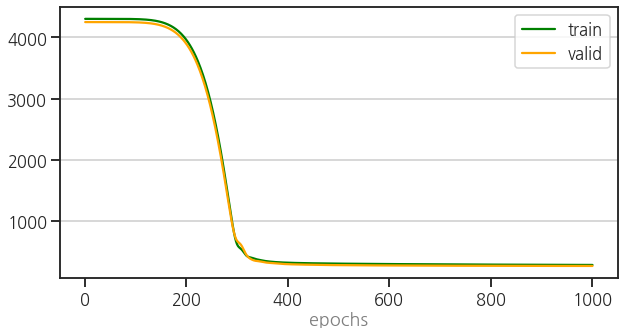

In [ ]:
X_Train_pp = preprocessor.fit_transform(X_Train)
X_Train_tensor = torch.Tensor(X_Train_pp).to(device)
y_Train_tensor = torch.Tensor(y_Train).to(device)

net = Net().to(device)
loss_fn = RMSELoss()                        # loss function 지정
optimizer = optim.Adam(net.parameters(), 
                       lr=1e-3)             # learning rate = 0.001
epochs = 1000
net = train(device, net, epochs, loss_fn, optimizer, X_Train_tensor, y_Train_tensor, X_val_tensor, y_val_tensor, early_stopping=0)

In [ ]:
with torch.no_grad():
    y_pred_test = net.forward(X_test_tensor).cpu().numpy().flatten()

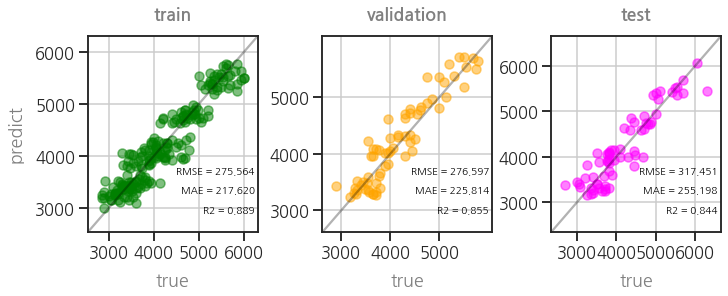

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)

trues = [y_train, y_val, y_test]
preds = [y_pred_train, y_pred_val, y_pred_test]
colors = [c_train, c_val, c_test]
titles = ["train", "validation", "test"]
for ax, true, pred, c, title in zip(axs, trues, preds, colors, titles):
    plot_parity(true, pred, ax=ax, scatter_kws={"fc":c, "ec":c, "alpha":0.5}, title=title)
    if ax != axs[0]:
        ax.set_ylabel("")

In [ ]:
def plot_parity3(model, target=["train", "val", "test"], figsize=(10, 4),
                 Xs=None, trues=None, preds=None, colors=None):
    if not Xs:
        Xs = [eval(f"X_{t}") for t in target]
    if not trues:
        trues = [eval(f"y_{t}") for t in target]
    if not preds:
        preds = [model.predict(X) for X in Xs]
    if not colors:
        colors = [eval(f"c_{t}") for t in target]

    fig, axs = plt.subplots(ncols=len(target), figsize=figsize, constrained_layout=True)
    for ax, true, pred, c, title in zip(axs, trues, preds, colors, titles):
        plot_parity(true, pred, ax=ax, scatter_kws={"fc":c, "ec":c, "alpha":0.5}, title=title)
        if ax != axs[0]:
            ax.set_ylabel("")

## 3.2. skorch

In [ ]:
!pip install skorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 155 kB 7.3 MB/s 


### 3.2.1. skorch로 PyTorch wrapping

* NeuralNetRegressor()로 PyTorch neural network wrapping

In [42]:
import skorch
from skorch import NeuralNetRegressor

# skorch로 PyTorch neural network wrapping
net_sk = NeuralNetRegressor(Net(), device=device, 
                            criterion=RMSELoss,         # loss function
                            optimizer=optim.Adam,       # optimizer
                            optimizer__lr=1e-3,         # learning rate of the optimizer
                            verbose=0)                  # 너무 긴 출력 방지

# training
for epoch in range(300):
    net_sk.fit(X_train_np, y_train.astype(np.float32).values.reshape(-1, 1))

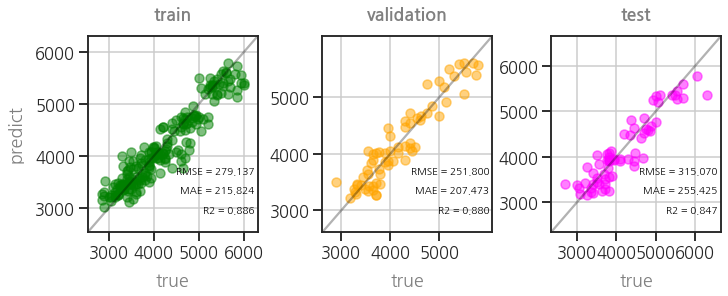

In [43]:
# prediction
y_pred_train = net_sk.predict(X_train_np)
y_pred_val = net_sk.predict(X_val_np)
y_pred_test = net_sk.predict(X_test_np)

# parity plot
plot_parity3(net_sk, Xs=[X_train_np, X_val_np, X_test_np])

### 3.2.2. ML pipeline 작성

* Pipeline에 preprocessor와 함께 이식
* linear regression, random forest 선택 가능 구현

In [44]:
# machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# embedding pytorch model in scikit-learn Pipeline
from skorch import NeuralNetRegressor
from skorch.helper import predefined_split
from skorch.callbacks import Callback

# dynamic input size of the PyTorch module
#- https://stackoverflow.com/questions/60005715/how-to-pass-input-dim-from-fit-method-to-skorch-wrapper/60170023#60170023
class InputShapeSetter(Callback):
    def on_train_begin(self, net, X, y):
        net.set_params(module__ninput=X.shape[1])

def get_model(method="lr", device=device, cols_cat=cols_cat, cols_num=cols_num, degree=1, 
              callbacks=[InputShapeSetter()], **kwargs):
    if method == "lr":
        ml = LinearRegression(fit_intercept=True)
    elif method == "rf":
        ml = RandomForestRegressor(random_state=rng)
    elif method == "nn":
        ml = NeuralNetRegressor(Net(), device=device, callbacks=callbacks, **kwargs)
    else:
        print("# 'method' should be in ['lr', 'rf', 'nn'].")
        return None
    
    preprocessor = get_preprocessor(cols_cat=cols_cat, cols_num=cols_num, degree=degree)
    model = Pipeline([("preprocessor", preprocessor), 
                      ("ml", ml)])
    
    return model

In [45]:
model = get_model("nn", max_epochs=epochs, verbose=1, criterion=RMSELoss, optimizer=optim.Adam, optimizer__lr = 1e-3)
model

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('concat',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['species',
                                                                    'island',
                                                                    'sex']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('polynomial',
                                                                                    PolynomialFeatures(degree=1)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['bill_length_mm',
                                                                    'bill_depth_mm',
                                                                    'flipper_length_mm'])])),
                                 ('f...
                 <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=Net(
    (layer0): Linear(in_features=12, out_features=16, bias=True)
    (layer1): Linear(in_features=16, out_features=16, bias=True)
    (layer2): Linear(in_features=16, out_features=12, bias=True)
    (layer3): Linear(in_features=12, out_features=8, bias=True)
    (layer4): Linear(in_features=8, out_features=1, bias=True)
    (activation): ReLU()
  ),
))])

* Pipeline 내 PyTorch 모델 설정 확인

In [46]:
model["ml"].get_params()

{'_kwargs': {'optimizer__lr': 0.001},
 'batch_size': 128,
 'callbacks': [<__main__.InputShapeSetter at 0x7ff6dc228b10>],
 'callbacks__epoch_timer': <skorch.callbacks.logging.EpochTimer at 0x7ff6dc3fd8d0>,
 'callbacks__print_log': <skorch.callbacks.logging.PrintLog at 0x7ff6dc3fdf50>,
 'callbacks__print_log__floatfmt': '.4f',
 'callbacks__print_log__keys_ignored': None,
 'callbacks__print_log__sink': <function print>,
 'callbacks__print_log__stralign': 'right',
 'callbacks__print_log__tablefmt': 'simple',
 'callbacks__train_loss': <skorch.callbacks.scoring.PassthroughScoring at 0x7ff6dc3fded0>,
 'callbacks__train_loss__lower_is_better': True,
 'callbacks__train_loss__name': 'train_loss',
 'callbacks__train_loss__on_train': True,
 'callbacks__valid_loss': <skorch.callbacks.scoring.PassthroughScoring at 0x7ff6dc3fde10>,
 'callbacks__valid_loss__lower_is_better': True,
 'callbacks__valid_loss__name': 'valid_loss',
 'callbacks__valid_loss__on_train': False,
 'criterion': __main__.RMSELoss,


### 3.2.3. train and validate (self)

In [47]:
model.fit(X_train, y_train.values.reshape(-1, 1).astype(np.float32))

Re-initializing module because the following parameters were re-set: module__ninput.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     4280.4363     4388.0942  0.0140
      2     4280.4286     4388.0869  0.0095
      3     4280.4212     4388.0791  0.0095
      4     4280.4140     4388.0718  0.0092
      5     4280.4070     4388.0649  0.0096
      6     4280.3998     4388.0571  0.0101
      7     4280.3930     4388.0498  0.0094
      8     4280.3856     4388.0425  0.0067
      9     4280.3782     4388.0342  0.0083
     10     4280.3705     4388.0264  0.0075
     11     4280.3627     4388.0186  0.0082
     12     4280.3549     4388.0103  0.0098
     13     4280.3470     4388.0024  0.0104
     14     4280.3392     4387.9941  0.0089
     15     4280.3310     4387.9858  0.0069
     16     4280.3226     4387.9771  0.0098
     17     4280.3147     4387.9688  0.0068
     18     4280.3060    

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('concat',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['species',
                                                                    'island',
                                                                    'sex']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('polynomial',
                                                                                    PolynomialFeatures(degree=1)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['bill_length_mm',
                                                                    'bill_depth_mm',
                                                                    'flipper_length_mm'])])),
                                 ('f...
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (layer0): Linear(in_features=12, out_features=16, bias=True)
    (layer1): Linear(in_features=16, out_features=16, bias=True)
    (layer2): Linear(in_features=16, out_features=12, bias=True)
    (layer3): Linear(in_features=12, out_features=8, bias=True)
    (layer4): Linear(in_features=8, out_features=1, bias=True)
    (activation): ReLU()
  ),
))])

* learning curve

<AxesSubplot:xlabel='epochs'>

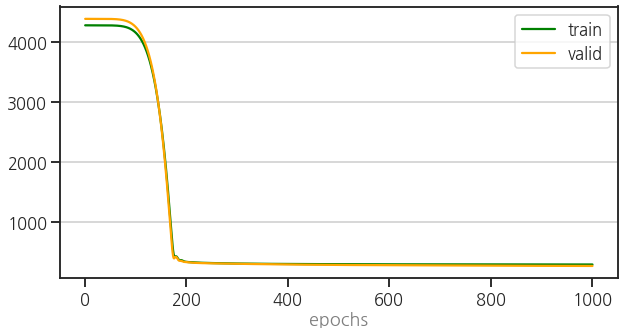

In [48]:
history = model["ml"].history
train_loss = history[:, "train_loss"]
valid_loss = history[:, "valid_loss"]

plot_epoch(train_loss, valid_loss)

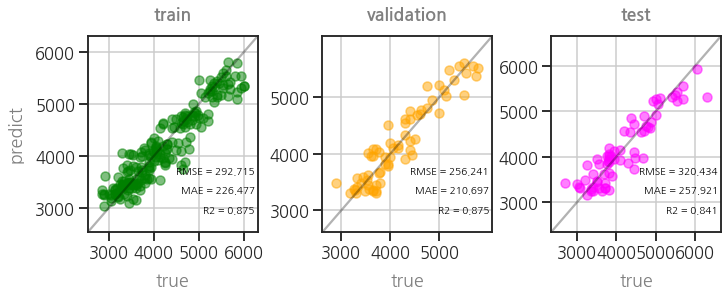

In [49]:
plot_parity3(model)

### 3.2.4. train and validate (predefined validation set)

In [50]:
from skorch.dataset import Dataset

# ys (numpy)
y_train_np = y_train.values.reshape(-1, 1).astype(np.float32)
y_val_np = y_val.values.reshape(-1, 1).astype(np.float32)
y_test_np = y_test.values.reshape(-1, 1).astype(np.float32)

# predefined validation set
preprocessor = get_preprocessor()
X_val_pp = preprocessor.fit(X_train).transform(X_val)
valid_dataset = Dataset(X_val_pp, y_val_np)

# model training
model = get_model("nn", max_epochs=epochs, verbose=1, criterion=RMSELoss, optimizer=optim.Adam, optimizer__lr = 1e-3,
                  # predefined validataion set
                  train_split=predefined_split(valid_dataset))  
model.fit(X_train, y_train_np)

Re-initializing module because the following parameters were re-set: module__ninput.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     4301.9705     4250.3496  0.0081
      2     4301.9564     4250.3354  0.0096
      3     4301.9427     4250.3213  0.0093
      4     4301.9286     4250.3076  0.0101
      5     4301.9147     4250.2935  0.0089
      6     4301.9006     4250.2793  0.0094
      7     4301.8867     4250.2656  0.0100
      8     4301.8728     4250.2520  0.0092
      9     4301.8588     4250.2373  0.0125
     10     4301.8449     4250.2231  0.0112
     11     4301.8308     4250.2090  0.0119
     12     4301.8161     4250.1943  0.0076
     13     4301.8015     4250.1792  0.0135
     14     4301.7866     4250.1641  0.0118
     15     4301.7713     4250.1484  0.0111
     16     4301.7559     4250.1323  0.0132
     17     4301.7398     4250.1162  0.0118
     18     4301.7232    

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('concat',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['species',
                                                                    'island',
                                                                    'sex']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('polynomial',
                                                                                    PolynomialFeatures(degree=1)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['bill_length_mm',
                                                                    'bill_depth_mm',
                                                                    'flipper_length_mm'])])),
                                 ('f...
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (layer0): Linear(in_features=12, out_features=16, bias=True)
    (layer1): Linear(in_features=16, out_features=16, bias=True)
    (layer2): Linear(in_features=16, out_features=12, bias=True)
    (layer3): Linear(in_features=12, out_features=8, bias=True)
    (layer4): Linear(in_features=8, out_features=1, bias=True)
    (activation): ReLU()
  ),
))])

* learning curve

<AxesSubplot:xlabel='epochs'>

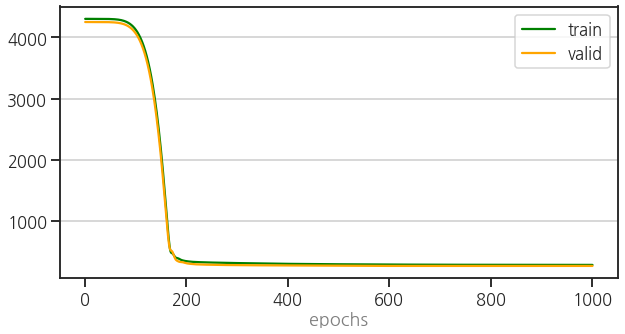

In [51]:
history = model["ml"].history
train_loss_0 = history[:, "train_loss"]
valid_loss_0 = history[:, "valid_loss"]

plot_epoch(train_loss_0, valid_loss_0)

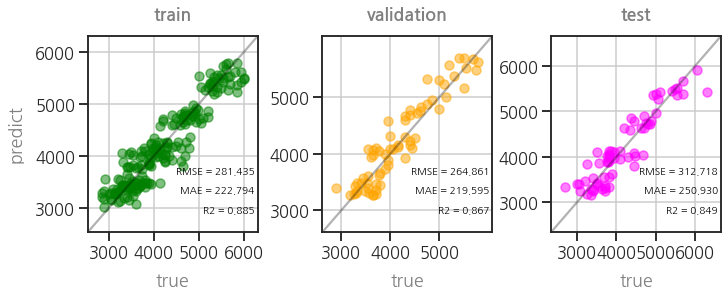

In [52]:
plot_parity3(model)

### 3.2.5. learning rate scheduler

In [53]:
from skorch.callbacks import LRScheduler

model = get_model("nn", max_epochs=epochs, verbose=1, criterion=RMSELoss, optimizer=optim.Adam, optimizer__lr = 1e-3,
                  train_split=predefined_split(valid_dataset),               # predefined validataion set                
                  callbacks=[# input dimension setter
                             ("input_shape_setter", InputShapeSetter()),
                             
                             # LR scheduler
                             ("lr_scheduler", LRScheduler(policy=OneCycleLR, 
                                                         max_lr=0.1,
                                                         total_steps=epochs))])
model.fit(X_train, y_train_np)

Re-initializing module because the following parameters were re-set: module__ninput.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1     4302.3803     4250.7417  0.0040  0.0125
      2     4302.3435     4250.7036  0.0040  0.0077
      3     4302.3053     4250.6641  0.0040  0.0102
      4     4302.2659     4250.6211  0.0040  0.0096
      5     4302.2230     4250.5737  0.0040  0.0061
      6     4302.1754     4250.5176  0.0041  0.0093
      7     4302.1183     4250.4473  0.0041  0.0092
      8     4302.0471     4250.3564  0.0041  0.0125
      9     4301.9544     4250.2427  0.0042  0.0104
     10     4301.8388     4250.0981  0.0042  0.0094
     11     4301.6918     4249.9141  0.0043  0.0086
     12     4301.5039     4249.6777  0.0043  0.0083
     13     4301.2617     4249.3726  0.0044  0.0097
     14     4300.9496     4248.9819  0.0044  0.0093
     15     4300.5488     424

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('concat',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['species',
                                                                    'island',
                                                                    'sex']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('polynomial',
                                                                                    PolynomialFeatures(degree=1)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['bill_length_mm',
                                                                    'bill_depth_mm',
                                                                    'flipper_length_mm'])])),
                                 ('f...
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (layer0): Linear(in_features=12, out_features=16, bias=True)
    (layer1): Linear(in_features=16, out_features=16, bias=True)
    (layer2): Linear(in_features=16, out_features=12, bias=True)
    (layer3): Linear(in_features=12, out_features=8, bias=True)
    (layer4): Linear(in_features=8, out_features=1, bias=True)
    (activation): ReLU()
  ),
))])

* learning curve

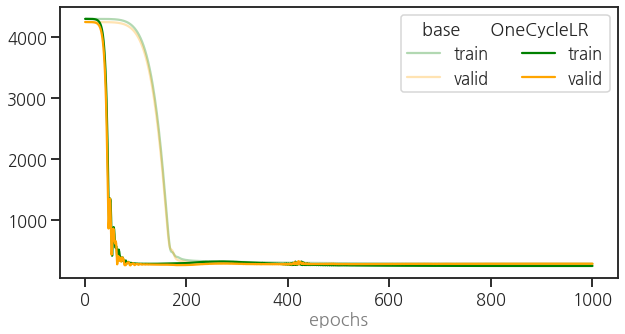

In [54]:
ax = plot_epoch(train_loss_0, valid_loss_0)
lines = ax.lines
for line in lines:
    line.set_alpha(0.3)

history = model["ml"].history
train_loss = history[:, "train_loss"]
valid_loss = history[:, "valid_loss"]

ax = plot_epoch(train_loss, valid_loss, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, ncol=2, title="base      OneCycleLR")

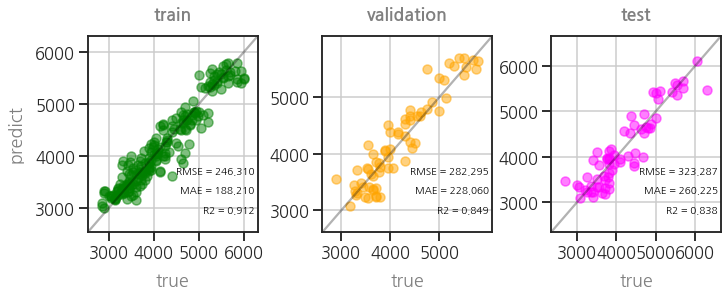

In [55]:
plot_parity3(model)

### 3.2.6. early stopping

In [56]:
from skorch.callbacks import EarlyStopping

model = get_model("nn", max_epochs=epochs, verbose=1, criterion=RMSELoss, optimizer=optim.Adam, optimizer__lr = 1e-3,
                  train_split=predefined_split(valid_dataset),               # predefined validataion set        

                  callbacks=[# input dimension setter
                             ("input_shape_setter", InputShapeSetter()),

                             # LR scheduler
                             ("lr_scheduler", LRScheduler(policy=OneCycleLR, 
                                                         max_lr=0.1,
                                                         total_steps=epochs)),

                             # early stopping
                             ("early_stopping", EarlyStopping(monitor="valid_loss",
                                                              patience=20))])
model.fit(X_train, y_train.values.reshape(-1, 1).astype(np.float32))

Re-initializing module because the following parameters were re-set: module__ninput.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1     4302.0807     4250.4473  0.0040  0.0145
      2     4302.0493     4250.4136  0.0040  0.0085
      3     4302.0151     4250.3765  0.0040  0.0075
      4     4301.9776     4250.3354  0.0040  0.0074
      5     4301.9359     4250.2886  0.0040  0.0106
      6     4301.8887     4250.2363  0.0041  0.0067
      7     4301.8351     4250.1772  0.0041  0.0093
      8     4301.7749     4250.1099  0.0041  0.0091
      9     4301.7062     4250.0317  0.0042  0.0089
     10     4301.6261     4249.9404  0.0042  0.0088
     11     4301.5331     4249.8359  0.0043  0.0084
     12     4301.4263     4249.7124  0.0043  0.0100
     13     4301.2993     4249.5635  0.0044  0.0090
     14     4301.1463     4249.3818  0.0044  0.0066
     15     4300.9587     424

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('concat',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['species',
                                                                    'island',
                                                                    'sex']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('polynomial',
                                                                                    PolynomialFeatures(degree=1)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['bill_length_mm',
                                                                    'bill_depth_mm',
                                                                    'flipper_length_mm'])])),
                                 ('f...
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (layer0): Linear(in_features=12, out_features=16, bias=True)
    (layer1): Linear(in_features=16, out_features=16, bias=True)
    (layer2): Linear(in_features=16, out_features=12, bias=True)
    (layer3): Linear(in_features=12, out_features=8, bias=True)
    (layer4): Linear(in_features=8, out_features=1, bias=True)
    (activation): ReLU()
  ),
))])

(0.0, 200.0)

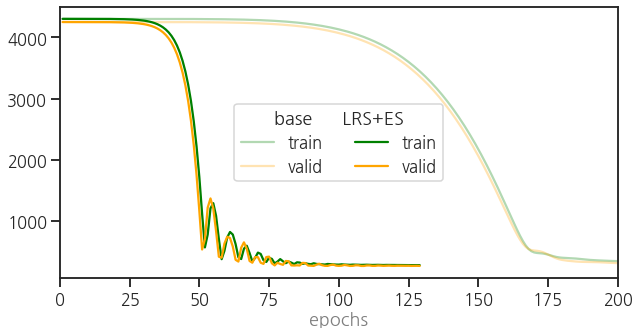

In [57]:
ax = plot_epoch(train_loss_0, valid_loss_0)
lines = ax.lines
for line in lines:
    line.set_alpha(0.3)

history = model["ml"].history
train_loss = history[:, "train_loss"]
valid_loss = history[:, "valid_loss"]

ax = plot_epoch(train_loss, valid_loss, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, ncol=2, title="base      LRS+ES")
ax.set_xlim(0, 200)

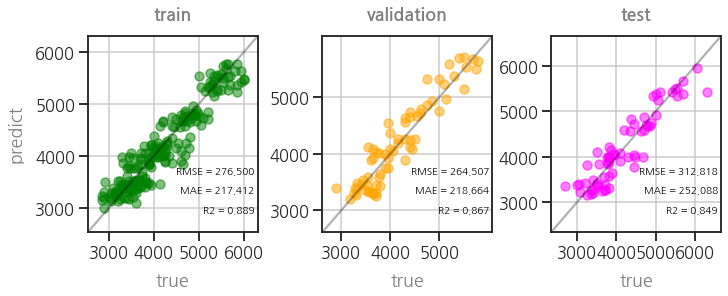

In [58]:
plot_parity3(model)

### 3.2.7. Saving and Loading (manual)

* https://skorch.readthedocs.io/en/stable/user/save_load.html

In [59]:
# save parameters
model["ml"].save_params(f_params="nn_params.pkl")

In [60]:
# load parameters
model_new = get_model(method="nn")
model_new["ml"].initialize()
model_new["ml"].load_params(f_params="nn_params.pkl")

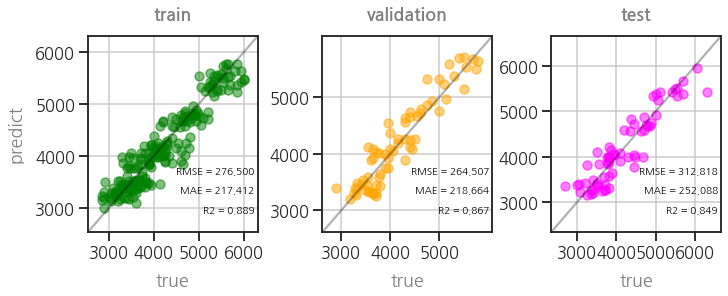

In [61]:
# check reproducibility
y_pred_train = model_new["ml"].predict(model["preprocessor"].transform(X_train))
y_pred_val = model_new["ml"].predict(model["preprocessor"].transform(X_val))
y_pred_test = model_new["ml"].predict(model["preprocessor"].transform(X_test))

plot_parity3(model_new, preds=[y_pred_train, y_pred_val, y_pred_test])

### 3.2.8. Saving and Loading (callbacks)

* https://skorch.readthedocs.io/en/stable/user/save_load.html#using-callbacks

In [83]:
from skorch.callbacks import Checkpoint, TrainEndCheckpoint

# save the model parameters, optimizer, and history
cp = Checkpoint(dirname='exp1')
train_end_cp = TrainEndCheckpoint(dirname='exp1')

model = get_model("nn", max_epochs=epochs, verbose=1, criterion=RMSELoss, optimizer=optim.Adam, optimizer__lr = 1e-3,
                  train_split=predefined_split(valid_dataset),                               

                  callbacks=[# input dimension setter
                             ("input_shape_setter", InputShapeSetter()),

                             # LR scheduler
                             ("lr_scheduler", LRScheduler(policy=OneCycleLR, 
                                                         max_lr=0.1,
                                                         total_steps=epochs)),

                             # early stopping
                             ("early_stopping", EarlyStopping(monitor="valid_loss",
                                                              patience=20)),
                             
                             # Checkpoints
                             ("checkpoint", cp),
                             ("train_end_checkpoint", train_end_cp)
                             ])
model.fit(X_train, y_train.values.reshape(-1, 1).astype(np.float32))

Re-initializing module because the following parameters were re-set: module__ninput.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp      lr     dur
-------  ------------  ------------  ----  ------  ------
      1     4302.1950     4250.5513     +  0.0040  0.0236
      2     4302.1526     4250.5063     +  0.0040  0.0105
      3     4302.1068     4250.4565     +  0.0040  0.0175
      4     4302.0570     4250.4072     +  0.0040  0.0105
      5     4302.0083     4250.3550     +  0.0040  0.0109
      6     4301.9558     4250.2974     +  0.0041  0.0118
      7     4301.8970     4250.2305     +  0.0041  0.0120
      8     4301.8287     4250.1494     +  0.0041  0.0126
      9     4301.7458     4250.0493     +  0.0042  0.0117
     10     4301.6441     4249.9263     +  0.0042  0.0108
     11     4301.5182     4249.7739     +  0.0043  0.0109
     12     4301.3632     4249.5859     +  0.0043  0.0140
     13     4301.1713     4249.3521     +  0.0044

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('concat',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['species',
                                                                    'island',
                                                                    'sex']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('polynomial',
                                                                                    PolynomialFeatures(degree=1)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['bill_length_mm',
                                                                    'bill_depth_mm',
                                                                    'flipper_length_mm'])])),
                                 ('f...
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (layer0): Linear(in_features=12, out_features=16, bias=True)
    (layer1): Linear(in_features=16, out_features=16, bias=True)
    (layer2): Linear(in_features=16, out_features=12, bias=True)
    (layer3): Linear(in_features=12, out_features=8, bias=True)
    (layer4): Linear(in_features=8, out_features=1, bias=True)
    (activation): ReLU()
  ),
))])

(0.0, 200.0)

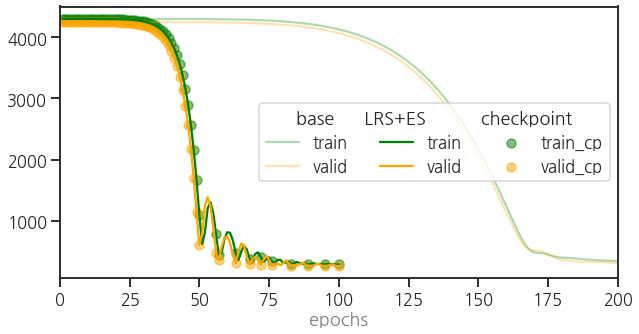

In [103]:
from skorch.history import History

# base plot
ax = plot_epoch(train_loss_0, valid_loss_0)
lines = ax.lines
for line in lines:
    line.set_alpha(0.3)

# history
history = History().from_file("./exp1/history.json")
train_loss = history[:, "train_loss"]
valid_loss = history[:, "valid_loss"]
ax = plot_epoch(train_loss, valid_loss, ax=ax)

# event_cp : cp == True
epoch = history[:, "epoch"]
event_cp = history[:, "event_cp"]
df_cp = pd.DataFrame({"epoch":epoch, "event_cp":event_cp, "train_loss":train_loss, "valid_loss":valid_loss})
df_cp = df_cp.loc[df_cp["event_cp"]==True]

ax.scatter(df_cp["epoch"], df_cp["train_loss"], fc=c_train, alpha=0.5, label="train_cp")
ax.scatter(df_cp["epoch"], df_cp["valid_loss"], fc=c_val, alpha=0.5, label="valid_cp")

ax.legend(ncol=3, title="base      LRS+ES           checkpoint", loc="center right")
ax.set_xlim(0, 200)

### 3.2.9. valid loss가 가장 적었던 checkpoint 불러서 learning rate 낮추기

In [104]:
from skorch.callbacks import LoadInitState

cp = Checkpoint(dirname='exp1')
load_state = LoadInitState(cp)

model = get_model("nn", max_epochs=epochs, verbose=1, criterion=RMSELoss, optimizer=optim.Adam, 
                  # learning rate 조정
                  optimizer__lr = 1e-5,

                  # predefined validataion set
                  train_split=predefined_split(valid_dataset),                               

                  callbacks=[# input dimension setter
                             ("input_shape_setter", InputShapeSetter()),

                             # early stopping
                             ("early_stopping", EarlyStopping(monitor="valid_loss",
                                                              patience=100)),
                             
                             # Checkpoints
                             ("checkpoint", cp),
                             ("load_initial_state", load_state)
                             ])
model.fit(X_train, y_train.values.reshape(-1, 1).astype(np.float32))

Re-initializing module because the following parameters were re-set: module__ninput.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
    101      289.8677      269.9875     +  0.0286
    102      286.1898      280.0203        0.0164
    103      284.5974      269.8845     +  0.0144
    104      282.8989      263.0171     +  0.0147
    105      286.5595      266.0045        0.0151
    106      285.3394      275.5753        0.0173
    107      283.7436      274.2149        0.0155
    108      282.0318      265.2479        0.0150
    109      283.4320      263.7422        0.0148
    110      284.4372      269.5782        0.0179
    111      282.9554      273.5562        0.0163
    112      281.6943      268.2310        0.0152
    113      281.6350      264.7169        0.0149
    114      283.1421      267.2518        0.0155
    115      282.5224      271.7520        0.0153
    116    

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('concat',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['species',
                                                                    'island',
                                                                    'sex']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('polynomial',
                                                                                    PolynomialFeatures(degree=1)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['bill_length_mm',
                                                                    'bill_depth_mm',
                                                                    'flipper_length_mm'])])),
                                 ('f...
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (layer0): Linear(in_features=12, out_features=16, bias=True)
    (layer1): Linear(in_features=16, out_features=16, bias=True)
    (layer2): Linear(in_features=16, out_features=12, bias=True)
    (layer3): Linear(in_features=12, out_features=8, bias=True)
    (layer4): Linear(in_features=8, out_features=1, bias=True)
    (activation): ReLU()
  ),
))])

### 3.2.10. Saving and Loading (model itself)

In [66]:
# saving
with open('skorch_dl.pkl', 'wb') as f:
    pickle.dump(model, f)

In [67]:
# loading
with open('skorch_dl.pkl', 'rb') as f:
    model_pkl = pickle.load(f)

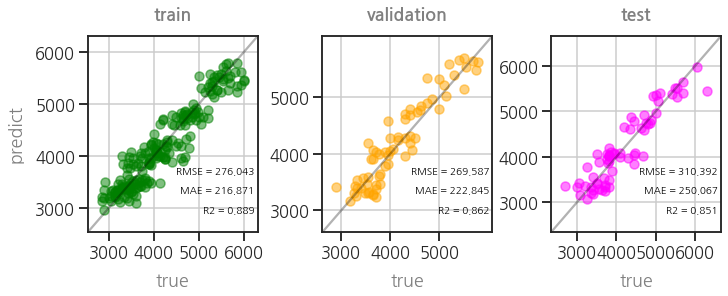

In [68]:
# check reproducibility
plot_parity3(model=model_pkl)

# 4. Summary: functions

## 4.1. skorch ML Pipeline

* scikit-learn preprocessor

In [105]:
# preprocessors
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessings for Categorical and Numerical features
def get_concat(cols_cat=cols_cat, cols_num=cols_num, degree=1):
    # categorical features: one-hot encoding
    cat_features = cols_cat
    cat_transformer = OneHotEncoder(sparse=False, handle_unknown="ignore")

    # numerical features: standard scaling & polynomial features
    num_features = cols_num
    num_transformer = Pipeline(steps=[("polynomial", PolynomialFeatures(degree=degree)),
                                      ("scaler", StandardScaler())])
    
    numcat = ColumnTransformer(transformers=[("categorical", cat_transformer, cat_features),
                                          ("numerical", num_transformer, num_features)])
    return numcat

# Float64 to Float32 for PyTorch
class FloatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.array(X, dtype=np.float32)


# preprocessing Pipeline
def get_preprocessor(cols_cat=cols_cat, cols_num=cols_num, degree=1):
    concat = get_concat(cols_cat=cols_cat, cols_num=cols_num, degree=degree)
    ft = FloatTransformer()

    pipeline= Pipeline(steps=[("concat", concat), 
                              ("float64to32", ft)])
    return pipeline

* PyTorch Neural Network

In [111]:
import torch
from torch import nn
from torch import optim

# neural network: ninput(12)-16-16-12-8-1
class Net(nn.Module):
    def __init__(self, ninput=12):
        super().__init__()
        self.layer0 = nn.Linear(ninput, 16)
        self.layer1 = nn.Linear(16, 16)
        self.layer2 = nn.Linear(16, 12)
        self.layer3 = nn.Linear(12, 8)
        self.layer4 = nn.Linear(8, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer0(x))
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x)
        return x

# loss: RMSE
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
    def forward(self, true, pred):
        loss = torch.sqrt(self.mse(true, pred) + self.eps)
        return loss

* skorch ML Pipeline

In [119]:
# machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# embedding pytorch model in scikit-learn Pipeline
from skorch import NeuralNetRegressor
from skorch.helper import predefined_split

# callbacks
from skorch.callbacks import Callback
from skorch.callbacks import LRScheduler
from skorch.callbacks import EarlyStopping
from skorch.callbacks import Checkpoint, TrainEndCheckpoint

# dynamic input size of the PyTorch module
class InputShapeSetter(Callback):
    def on_train_begin(self, net, X, y):
        net.set_params(module__ninput=X.shape[1])

# save the model parameters, optimizer, and history
cp = Checkpoint(dirname='exp_test')
train_end_cp = TrainEndCheckpoint(dirname='exp_test')

# skorch ML pipeline
def get_model(method="lr", device=device, cols_cat=cols_cat, cols_num=cols_num, degree=1, 
              callbacks=[("input_shape_setter", InputShapeSetter()),
                         ("lr_scheduler", LRScheduler(policy=OneCycleLR, max_lr=0.1, total_steps=epochs)),
                         ("early_stopping", EarlyStopping(monitor="valid_loss", patience=20)),
                         ("checkpoint", cp), ("train_end_checkpoint", train_end_cp)], 
              **kwargs):
    
    if method == "lr":
        ml = LinearRegression(fit_intercept=True)
    elif method == "rf":
        ml = RandomForestRegressor(random_state=rng)
    elif method == "nn":
        ml = NeuralNetRegressor(Net(), device=device, callbacks=callbacks, **kwargs)
    else:
        print("# 'method' should be in ['lr', 'rf', 'nn'].")
        return None
    
    preprocessor = get_preprocessor(cols_cat=cols_cat, cols_num=cols_num, degree=degree)
    model = Pipeline([("preprocessor", preprocessor), 
                      ("ml", ml)])
    
    return model

## 4.2. visualizations

* learning curve

In [120]:
def plot_epoch(history=None, loss_trains=None, loss_vals=None, ax=None):
    
    if any([history, loss_trains]) == False:
        print("# one of 'history' and 'loss_trains' has to be used!")
        return ax
    
    if ax == None:
        fig, ax = plt.subplots(figsize=(10, 5))

    if loss_trains == None:
        loss_trains = history[:, "train_loss"]

    if history != None and loss_vals == None:
        loss_vals = history[:, "valid_loss"]

    ax.plot(list(range(1, len(loss_trains)+1)), loss_trains, c=c_train, label="train")
    if loss_vals != None:
        ax.plot(list(range(1, len(loss_vals)+1)), loss_vals, c=c_val, label="valid")
    ax.grid(axis="y")
    ax.set_xlabel("epochs", fontdict=font_label)
    ax.legend()

    return ax

* parity plots

In [121]:
def plot_parity3(model, target=["train", "val", "test"], figsize=(10, 4),
                 Xs=None, trues=None, preds=None, colors=None):
    if not Xs:
        Xs = [eval(f"X_{t}") for t in target]
    if not trues:
        trues = [eval(f"y_{t}") for t in target]
    if not preds:
        preds = [model.predict(X) for X in Xs]
    if not colors:
        colors = [eval(f"c_{t}") for t in target]

    fig, axs = plt.subplots(ncols=len(target), figsize=figsize, constrained_layout=True)
    for ax, true, pred, c, title in zip(axs, trues, preds, colors, titles):
        plot_parity(true, pred, ax=ax, scatter_kws={"fc":c, "ec":c, "alpha":0.5}, title=title)
        if ax != axs[0]:
            ax.set_ylabel("")

## 4.3. test run

Re-initializing module because the following parameters were re-set: module__ninput.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp      lr     dur
-------  ------------  ------------  ----  ------  ------
      1     4301.9874     4250.3501     +  0.0040  0.0135
      2     4301.9537     4250.3169     +  0.0040  0.0139
      3     4301.9202     4250.2832     +  0.0040  0.0133
      4     4301.8870     4250.2485     +  0.0040  0.0129
      5     4301.8518     4250.2104     +  0.0040  0.0147
      6     4301.8132     4250.1680     +  0.0041  0.0137
      7     4301.7702     4250.1187     +  0.0041  0.0126
      8     4301.7200     4250.0620     +  0.0041  0.0182
      9     4301.6623     4249.9951     +  0.0042  0.0203
     10     4301.5937     4249.9146     +  0.0042  0.0209
     11     4301.5116     4249.8169     +  0.0043  0.0121
     12     4301.4122     4249.6973     +  0.0043  0.0124
     13     4301.2894     4249.5493     +  0.0044

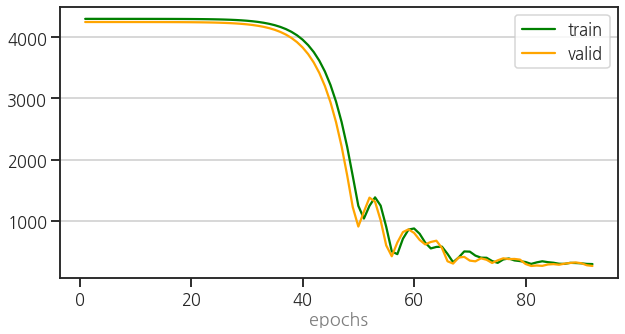

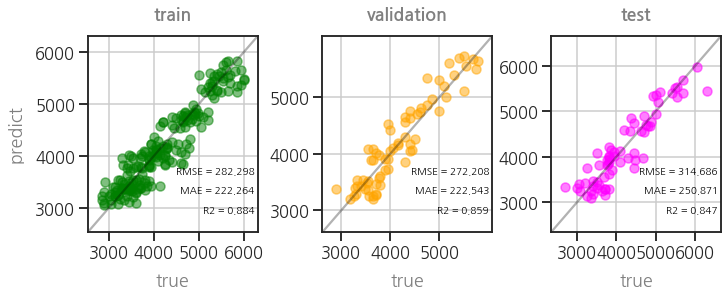

In [122]:
# predefined validation set
preprocessor = get_preprocessor()
X_val_pp = preprocessor.fit(X_train).transform(X_val)
valid_dataset = Dataset(X_val_pp, y_val_np)

# ML pipeline preparation
model_test = get_model("nn", max_epochs=epochs, verbose=1, criterion=RMSELoss, optimizer=optim.Adam, optimizer__lr = 1e-3,
                       train_split=predefined_split(valid_dataset))
model_test.fit(X_train, y_train_np)

# learning curve
history = History().from_file("./exp_test/history.json")
ax = plot_epoch(history)

# parity plots
plot_parity3(model_test)